![branding logo because i'm cool like that :)](dsols_logo.png)

# Business Case & Proof of Concept - Regression & Classification Algorihm with LinearLearner & SageMaker
Daniel Dickson - 20206675

COMM 493 - A1

Sunday, February 18, 2024

## Business Context

Business: 	Autumn Meadow Jewellery (onward, “the business”) is a small startup based 
in Oakville, Ontario, Canada.

Description:	The business is run by Ciara Rieder, and was founded in 2017. It is an 
e-commerce business running on the business-to-customer model, where the customer can order a product through the business’ website and have it shipped directly to their address.

Products:	The business provides handmade, one-of-a-kind jewellery items and 
Accessories, as well as various handmade decorations and ceramics.

Overview:	The solution being implemented aims to improve the tailoring of products to 
		what customers actually want based on browsing habits of similar customers 
as identified by LinearLearner. This will increase efficiency and tell business 
administration where to focus their production to increase consumer interest 
and sales.


## Opportunity Description

The business operates by selling custom pieces, many of which are themed or related to other pieces. As it can take a significant amount of time to make one product and the business is very small in staffing, it would be very inefficient to make several products that do not attract as much attention as existing products in other collections. A more efficient strategy would be to invest in the creation of products that are shown to be appealing to users, however manually examining pages of web-traffic data can be exhausting or overwhelming, and use up a lot more time that could instead be used to create products or further the business in other means. LinearLearner provides an opportunity to gather this data and analyze these trends on its own, then display them in an easy-to-understand way, thereby saving business administration lots of time while also helping them make the business more appealing to their potential consumers.


## Solution Description

Once the solution has been successfully implemented, the business will see many benefits. First and foremost, customer experience shall be greatly improved. As customers browse the product inventory, trends from previous browsers and buyers will be analyzed to suggest other relevant products the customer may be interested in. This will increase engagement and possibly inspire more purchases, as the customer will be more likely to ultimately find a product of sufficient interest to them. Additionally, consumer trends can be easily analyzed for the benefit of both the consumer and the business. LinearLearner can identify more popular items according to what website visitors are looking at or purchasing. These trends can then be displayed to business administration to get an idea of the types of products that should continue to be created, and also help consumers easily find these products once created. The knowledge of what products are popular can be used to help better understand the consumer base's wants and help attract more sales by developing similarly themed or categorized products, and identifying such products to the user can increase engagement and further the likelihood of finding an appealing product to the user, ultimately leading to increased sales.


## Proof of Concept & Business Goals

As the business model mainly focuses on handmade, custom pieces, identifying trends in user interests can provide a huge advantage in terms of market competitiveness. By knowing what consumers are interested in and tailoring the inventory to appeal to this demographic, the business can create inventory more personalized to potential consumers who are already interested in its inventory, thus increasing the likelihood of sales and recommendations. Identifying these trends can also help business administration better understand who their actual demographic of consumers is. By better understanding who the consumers are, it will be easier for the business to understand and tailor to their needs.

The dataset chosen for the example model is the “Customer Shopping Trends Dataset” by Sourav Banerjee, retrieved from Kaggle. The dataset is perhaps a little more expansive than the business will require, so some unnecessary columns (ex. subscription status, customer ID,  product size) were trimmed from the dataset. The dataset contains 3 900 datapoints of consumer data, factoring in the age, gender, and location of the customer, as well as what item they purchased, the category of item (which can also be substituted for collection if the business prefers), location of purchaser, season the purchase was made in, review rating (out of 5) on the product, whether or not a discount or promo code was used, and how many previous purchases that customer has made from the business. This dataset was chosen, as it offers a variety of consumer demographic data, as well as many different products of various categories. Ideally, the business will be able to collect some basic demographic data on their customers to factor into training. The wide array of products sampled in the dataset can be correlated to the wide array of products and collections offered by the business. These fields are moreso currently meant as demonstrations of how the system would work; they can be customized as the business chooses.


## Code

In [1]:
"""
Imports... so many imports...
"""

import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.inputs import TrainingInput
import boto3
import os
import matplotlib.pyplot as plt
# Import the pandas library as 'pd' for data manipulation and analysis
import pandas as pd

# Import the train_test_split function from scikit-learn for data splitting
from sklearn.model_selection import train_test_split

from sagemaker import image_uris

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
"""
Begin SageMaker initialization.
"""

# Create a SageMaker session, which manages interactions with SageMaker services
sagemaker_session = sagemaker.Session()

# Get the IAM execution role used for SageMaker to access AWS resources
role = get_execution_role()

# Get the AWS region associated with the SageMaker session
region = sagemaker_session.boto_region_name

# Retrieve the container image URI for the SageMaker Linear Learner algorithm
container = image_uris.retrieve(framework='linear-learner', region=region)

### Here, we can see the dataset that is being used:

In [3]:
"""
Read & clean dataset, create copy of initial values for later use before modifying further.
"""

# read csv data file
df = pd.read_csv("shopping_trends_updated.csv")

# drop all entries with incomplete data if any exist
df = df.dropna()

# create dataset copy before any further modifications are made
dfcopy = df.copy()

# display cleaned dataset in a table to verify manually that it loaded in correctly and completely
df

,Age,Gender,Item Purchased,Category,Location,Discount Applied,Previous Purchases
0,55,Male,Blouse,Clothing,Kentucky,Yes,14
1,19,Male,Sweater,Clothing,Maine,Yes,2
2,50,Male,Jeans,Clothing,Massachusetts,Yes,23
3,21,Male,Sandals,Footwear,Rhode Island,Yes,49
4,45,Male,Blouse,Clothing,Oregon,Yes,31
...,...,...,...,...,...,...,...
3895,40,Female,Hoodie,Clothing,Virginia,No,32
3896,52,Female,Backpack,Accessories,Iowa,No,41
3897,46,Female,Belt,Accessories,New Jersey,No,24
3898,44,Female,Shoes,Footwear,Minnesota,No,24


### Let's first clean the dataset:

In [4]:
"""
Create a list of all the labels for evaluation later.
"""

# generate an array of all the unique values in a particular column of the dataset and convert it to a list
# for easier access later
genders = df["Gender"].unique()
gendersList = genders.tolist()

itemsForSale = df["Item Purchased"].unique()
itemsForSaleList = itemsForSale.tolist()

categories = df["Category"].unique()
categoriesList = categories.tolist()

locations = df["Location"].unique()
locationsList = locations.tolist()

print(itemsForSaleList)


['Blouse', 'Sweater', 'Jeans', 'Sandals', 'Sneakers', 'Shirt', 'Shorts', 'Coat', 'Handbag', 'Shoes', 'Dress', 'Skirt', 'Sunglasses', 'Pants', 'Jacket', 'Hoodie', 'Jewelry', 'T-shirt', 'Scarf', 'Hat', 'Socks', 'Backpack', 'Belt', 'Boots', 'Gloves']


In [5]:
"""
Turn string data in dataset to numerical data for analysis.
"""

# decide what ints to classify as based on position of the label in the labels list from the previous block
def chngValsGND(z):
    return gendersList.index(z)

def chngValsIFS(z):
    return itemsForSaleList.index(z)

def chngValsCAT(z):
    return categoriesList.index(z)

def chngValsLOC(z):
    return locationsList.index(z)

def chngValsBinary(z):
    if z == "Yes":
        return 1
    else:
        return 0

# ensure that this part is versatile; any number of options is accounted for in each category
# change strings to corresponding ints
df["Gender"] = df["Gender"].apply(chngValsGND)
df["Item Purchased"] = df["Item Purchased"].apply(chngValsIFS)
df["Category"] = df["Category"].apply(chngValsCAT)
df["Location"] = df["Location"].apply(chngValsLOC)
df["Discount Applied"] = df["Discount Applied"].apply(chngValsBinary)

# display dataset, showing the numbered classifications instead of the text labels
df

,Age,Gender,Item Purchased,Category,Location,Discount Applied,Previous Purchases
0,55,0,0,0,0,1,14
1,19,0,1,0,1,1,2
2,50,0,2,0,2,1,23
3,21,0,3,1,3,1,49
4,45,0,0,0,4,1,31
...,...,...,...,...,...,...,...
3895,40,1,15,0,41,0,32
3896,52,1,21,3,44,0,41
3897,46,1,22,3,32,0,24
3898,44,1,9,1,46,0,24


In [6]:
"""
Split data, initialize training and testing.
"""

# split into data (x) and target (y) variables
x = df.drop(["Item Purchased"], axis=1)
y = df["Item Purchased"]

# initialize data split variables and finalize splitting
# test data is 20% of total data, training is 80%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20206675)

# concatenate and export seperated data to csv files for convenience
shopping_train_data = pd.concat([y_train, x_train], axis=1)
shopping_test_data = pd.concat([y_test, x_test], axis=1)

shopping_train_data.to_csv("ShopData_Train.csv", header=False, index=False)
shopping_test_data.to_csv("ShopData_Test.csv", header=False, index=False)

In [7]:
"""
S3 bucket initialization
"""

# Define your Amazon S3 bucket and prefix for data storage
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/shop-data/classification'

# Paths to your local data files - replace with your actual file paths
local_train = 'ShopData_Train.csv'
local_test = 'ShopData_Test.csv'

# Upload the local training data to the specified S3 bucket and prefix
train_uri = sagemaker_session.upload_data(local_train, bucket=bucket, key_prefix=prefix)
test_uri = sagemaker_session.upload_data(local_test, bucket=bucket, key_prefix=prefix)

# Print the S3 URI for the training data
print("Training URI: ", train_uri)

# Print the S3 URI for the test data
print("Test URI: ", test_uri)

Training URI:  s3://sagemaker-us-east-1-891377082895/sagemaker/shop-data/classification/ShopData_Train.csv
Test URI:  s3://sagemaker-us-east-1-891377082895/sagemaker/shop-data/classification/ShopData_Test.csv


In [8]:
"""
Create the LinearLearner model and tune the hyperparameters (I couldn't get this to fully work unfortunately).
"""

from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

# Create a SageMaker Linear Learner estimator
linear_learner = sagemaker.estimator.Estimator(container,
                                               role, 
                                               instance_count=1, 
                                               instance_type='ml.m5.large',
                                               output_path=f's3://{bucket}/{prefix}/output',
                                               sagemaker_session=sagemaker_session)


# Set hyperparameters for the Linear Learner
linear_learner.set_hyperparameters(feature_dim=6,  # Number of input features (excluding target)
                                   mini_batch_size=20,  # Size of mini-batches for training
                                   predictor_type='regressor',  # Specify 'regressor' for regression
                                   normalize_data=True,  # Normalize input features
                                   normalize_label=True)  # Normalize target variable for regression
"""
linear_learner.fit({'train': train_uri})

# Specify hyperparameters to tune and their ranges
hyperparameter_ranges = {
    'wd': ContinuousParameter(1e-6, 1e-2),
    'l1': ContinuousParameter(1e-6, 1e-2),
    'learning_rate': ContinuousParameter(1e-6, 1e-2)
}

# Create a hyperparameter tuner
tuner = HyperparameterTuner(
    estimator=linear_learner,
    objective_metric_name='validation:mse',
    objective_type='Minimize',
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=10,
    max_parallel_jobs=2
)

# Launch the hyperparameter tuning job
tuner.fit({'train': train_uri, 'test': test_uri})
"""

"\nlinear_learner.fit({'train': train_uri})\n\n# Specify hyperparameters to tune and their ranges\nhyperparameter_ranges = {\n    'wd': ContinuousParameter(1e-6, 1e-2),\n    'l1': ContinuousParameter(1e-6, 1e-2),\n    'learning_rate': ContinuousParameter(1e-6, 1e-2)\n}\n\n# Create a hyperparameter tuner\ntuner = HyperparameterTuner(\n    estimator=linear_learner,\n    objective_metric_name='train:mse',\n    objective_type='Minimize',\n    hyperparameter_ranges=hyperparameter_ranges,\n    max_jobs=10,\n    max_parallel_jobs=2\n)\n\n# Launch the hyperparameter tuning job\ntuner.fit({'train': train_uri, 'test': test_uri})\n"

In [9]:
# Test the model
linear_learner.fit({'train': TrainingInput(train_uri, content_type='text/csv'),
                    'test': TrainingInput(test_uri, content_type='text/csv')})

INFO:sagemaker:Creating training-job with name: linear-learner-2024-02-24-07-00-40-419


2024-02-24 07:00:40 Starting - Starting the training job...
2024-02-24 07:00:54 Starting - Preparing the instances for training...
2024-02-24 07:01:36 Downloading - Downloading input data......
2024-02-24 07:02:16 Downloading - Downloading the training image......
2024-02-24 07:03:36 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[02/24/2024 07:03:40 INFO 140144685090624] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss'

### Endpoint Configuration

In [13]:
EndpointConfig="arn:aws:sagemaker:us-east-1:891377082895:endpoint/regression-linear-learner-endpoint"
Endpoint="regression-linear-learner-endpoint"

# delete existing endpoint if one exists
def delete_sagemaker_endpoint(endpoint_name):
    # Initialize SageMaker client
    sagemaker = boto3.client('sagemaker', region_name=region)
    
    try:
        # Check if the endpoint configuration exists
        response = sagemaker.describe_endpoint_config(EndpointConfigName=endpoint_name)
        
        # If the configuration exists, delete it
        if response:
            sagemaker.delete_endpoint_config(EndpointConfigName=endpoint_name)
            print(f"Endpoint configuration '{endpoint_name}' has been deleted.")
        
        # Check if the endpoint exists
        response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
        
        # If the endpoint exists, delete it
        if response:
            sagemaker.delete_endpoint(EndpointName=endpoint_name)
            print(f"Endpoint '{endpoint_name}' has been deleted.")
        
        return True  # Deletion successful
    except Exception as e:
        error_message = str(e)
        if "Could not find endpoint configuration" in error_message:
            print(f"Endpoint configuration '{endpoint_name}' not found. No action taken.")
            return True  # Configuration not found, exit gracefully
        elif "Could not find endpoint" in error_message:
            print(f"Endpoint '{endpoint_name}' not found. No action taken.")
            return True  # Endpoint not found, exit gracefully
        else:
            print(f"Error deleting SageMaker endpoint and configuration: {error_message}")
            return False  # Deletion failed
        
# Delete the Endpoint and Config
result = delete_sagemaker_endpoint(Endpoint)
if result:
    print(f"Endpoint '{Endpoint}' and its configuration have been deleted.")
else:
    print(f"Failed to delete endpoint '{Endpoint}' and its configuration.")
    
    
# Create a SageMaker client to interact with the SageMaker service
sagemaker_client = boto3.client('sagemaker')

# Deploy the Linear Learner model to the SageMaker endpoint
linear_predictor = linear_learner.deploy(
    initial_instance_count=1,  # Number of initial instances
    instance_type='ml.m5.large',  # Type of instance for serving
    endpoint_name=Endpoint  # Custom endpoint name
)

INFO:sagemaker:Creating model with name: linear-learner-2024-02-24-07-08-59-840


Endpoint configuration 'regression-linear-learner-endpoint' has been deleted.
Endpoint 'regression-linear-learner-endpoint' not found. No action taken.
Endpoint 'regression-linear-learner-endpoint' and its configuration have been deleted.


INFO:sagemaker:Creating endpoint-config with name regression-linear-learner-endpoint
INFO:sagemaker:Creating endpoint with name regression-linear-learner-endpoint


------!

In [15]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Set the serializer to CSV (Comma-Separated Values)
linear_predictor.serializer = CSVSerializer()

# Set the deserializer to JSON (JavaScript Object Notation)
linear_predictor.deserializer = JSONDeserializer()

# Sample hardcoded data point
sd = [29, 1, 0, 5, 1, 1]

# Convert the sample data to a CSV string
query_data_csv = ','.join([str(item) for item in sd])

# Querying the model and getting a prediction
response = linear_predictor.predict(query_data_csv)
item = response['predictions'][0]['score']
itemName = itemsForSaleList[int(round(item, 0))]

# for text formatting
if sd[4] == 1:
    disc = "Yes"
else:
    disc = "No"

# Print out the prediction
print("Suggested purchase for {} year old {}".format(sd[0], gendersList[sd[1]]))
print("Location: {}; Discount: {}; Previous Purchases: {}".format(locationsList[sd[3]], disc, sd[5]))
print("Predicted value:", itemName)

# Delete the Endpoint and Config
result = delete_sagemaker_endpoint(Endpoint)
if result:
    print(f"Endpoint '{Endpoint}' and its configuration have been deleted.")
else:
    print(f"Failed to delete endpoint '{Endpoint}' and its configuration.")

Suggested purchase for 29 year old Female
Location: Wyoming; Discount: Yes; Previous Purchases: 1
Predicted value: Handbag
Endpoint configuration 'regression-linear-learner-endpoint' has been deleted.
Endpoint 'regression-linear-learner-endpoint' has been deleted.
Endpoint 'regression-linear-learner-endpoint' and its configuration have been deleted.


## Plotting Datapoints

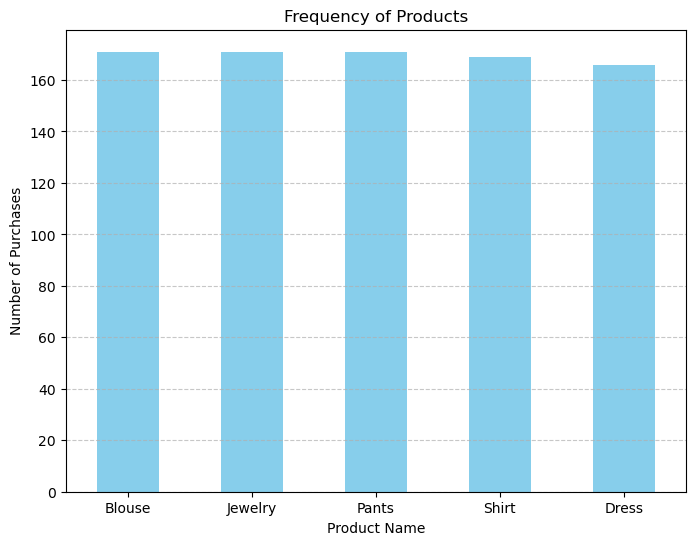

In [20]:
"""
Plot a graph of the frequency of each product that has been sold.
"""

productFreq = dfcopy['Item Purchased'].value_counts()

plt.figure(figsize=(8, 6))
productFreq.head(5).plot(kind='bar', color='skyblue')
plt.title('Frequency of Products')
plt.xlabel('Product Name')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

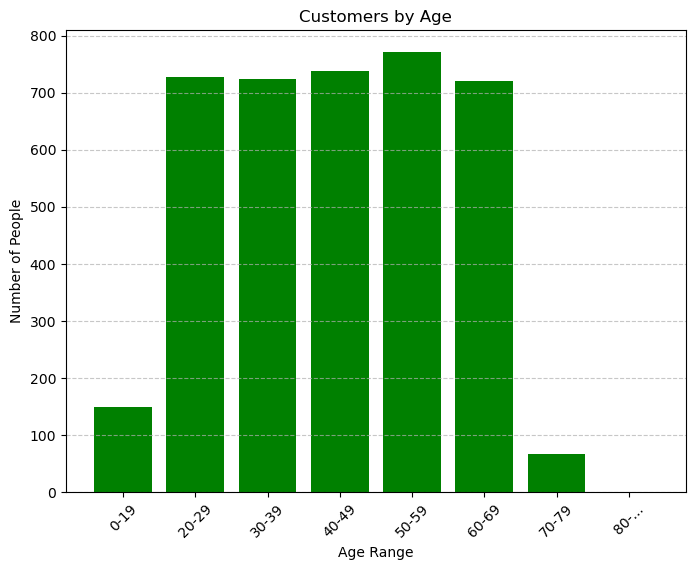

In [17]:
"""
Plot a graph of the age groups of previous customers.
"""

age_ranges = [(0, 19), (20, 29), (30, 39), (40, 49), (50, 59), (60, 69), (70, 79), (80, 999)]

# Count the number of people in each age range
age_counts = []
for age_range in age_ranges:
    lower_bound, upper_bound = age_range
    count = ((df['Age'] >= lower_bound) & (df['Age'] <= upper_bound)).sum()
    age_counts.append(count)

age_ranges[-1] = (age_ranges[-1][0], '...')
    
plt.figure(figsize=(8, 6))
plt.bar(range(len(age_ranges)), age_counts, color='green')
plt.title('Customers by Age')
plt.xlabel('Age Range')
plt.ylabel('Number of People')
plt.xticks(range(len(age_ranges)), [f'{lower}-{upper}' for lower, upper in age_ranges], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

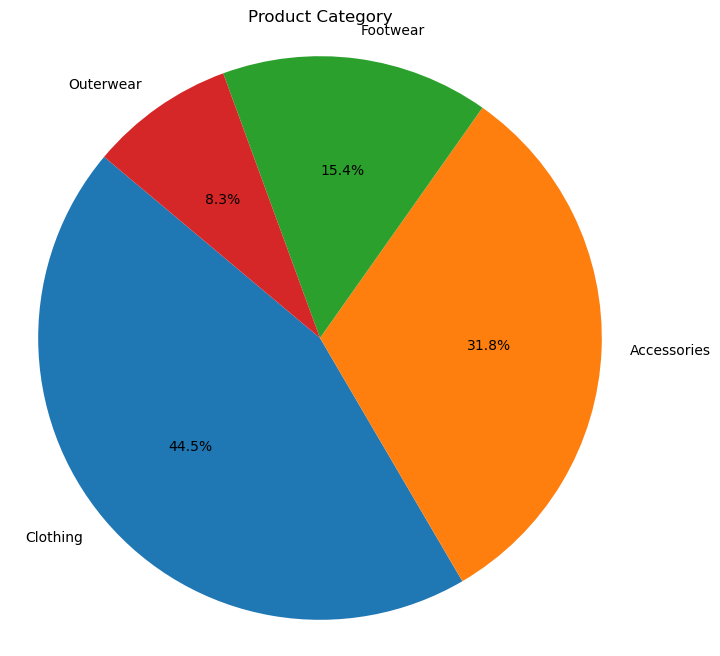

In [18]:
"""
Plot a chart of each category of purchased products.
"""
categoriesFreq = dfcopy['Category'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(categoriesFreq, labels=categoriesFreq.index, autopct='%1.1f%%', startangle=140)
plt.title('Product Category')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

This sort of data would be difficult to logically predict as each person has their own individual preferences independent of others, therefore a model would likely not have extremely high accuracy overall. However, initial tests showed the model to show an approximately 20% accuracy, meaning that the model’s suggestion correlated with 1 in 5 test subjects’ eventual purchases. For a small business, this can produce a significant increase in sales should this trend continue. By recommending customers even more products that they may be interested in, they are more likely to make a purchase, ultimately generating more revenue for the business. Additionally, simply because a customer is reported to have purchased one specific product does not mean that they might not be interested in others that they have not seen yet. By generally predicting what customers would want to purchase, the system can provide suggestions more tailored to each customer that can make them more likely to make a purchase from the business. The business administration can also run "what-if" scenarios on target demographics to get an idea of what larger demographics of customers are actually purchasing. This, of course, will continue to be updated as more purchases are made, and therefore, as more data becomes available.

## Business Changes

For the solution to be properly implemented, the business will need to finalize its ongoing switch from Etsy to a custom website. Once this is complete, the website must be enabled with cookies to track user interactions, and the solution must be integrated with this data to form a basis on which its estimations will be created. The business will also need to set up compatibility with Amazon Web Services (AWS), as the solution relies on AWS in order to function. Inventory decisions might change depending on how business administration interprets the results of the algorithm. The algorithm may also need to be updated depending on the data business administration is willing and able to gather and what they wish to see analyzed.


## Costs

![A summary of total monthly cost](cost.png)

The total cost is estimated to be around 125 CAD per month to use AWS, plus an additional 25/hour for approximately 80 hours of setup (as a competitive pay rate). In total, this amounts to 2000 for setup, and 125 monthly subsequently.

## Timeline

The initial consult after agreement will determine what, if any, changes should be made to the algorithm to collect and predict data based on the business' abilities and needs. Which data is necessary to visualize will also be discussed. On the first two days of development, these changes will be made as necessary.

The remainder of the time will be focused on integrating the service with the business' website, such that the business administration can easily access the data, and that the customers can properly see their product recommendations.

The model will need to be trained given actual business data, which will likely take around 10 minutes assuming the dataset is of a similar size to the test data. The data will also first need to be cleaned, though most of this structure is already built into the existing code.

Afterwards, a demonstration will be scheduled to business administration and relevant parties to learn how to use and interact with the system.

## Cost-Benefit Analysis

As previously noted, the testing data indicated a 20% accuracy in predictions. Assuming this rate is maintained in practice, a 1-in-5 browser increase in sales. Noting the average value of a product available for sale, the service is expected to increase monthly sales by around 30% due to increased marketing. After approximately four months of optimal use, the business will see a breakeven between generated revenue and system costs. Afterward, this will result in a positive return on investment.

## Change Management Plan

Business administration will need to be adequately trained in using and interpreting the algorithm. A live demonstration of the system will be scheduled once implemented for administration to learn how to interact with it. Detailed documentation will also be provided to use as a reference in the future. A feedback mechanism will be implemented into the system so that issues may be addressed as they arise, and monthly review meetings will be scheduled to discuss concerns, successes, or other general feedback.

We look forward to hearing from you in the near future.
